In [22]:
# Making Necessary Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from math import sqrt, log, exp, pi
import seaborn as sns
import pickle

In [23]:
# Importing the dataset
galaxies = pd.read_csv("galaxies.csv")
galaxies['x'] = galaxies['x']/1000
velocities = galaxies['x'].tolist()

In [24]:
#Calculate the density corresponding to each datapoint
def calculate_ys(data, pi_k, mu_k, sigma_k, K):
    ys = []
    for i in range(len(data)):
        sum = 0
        for k in range(K):
            sum = sum + pi_k[k]*norm.pdf(data[i], mu_k[k], sigma_k[k])
        ys.append(sum)
    return ys


In [25]:
# Function to calculate pi_i_k
def calculate_pi_ik(data, pi_k, mu_k, sigma_k, K):
    pi_i_k = np.zeros((len(data), K))
    for i in range(len(data)):
        for k in range(K):
            numerator = pi_k[k]*norm.pdf(data[i], mu_k[k], sigma_k[k])
            denominator = 0
            for j in range(K):
                denominator = denominator + pi_k[j]*norm.pdf(data[i], mu_k[j], sigma_k[j])
            pi_i_k[i][k] = numerator/denominator
    return pi_i_k


In [26]:
# Calculate the Likelihood Q value.

def calculate_q(data, pi_k, mu_k, sigma_k, K):
    sum = 0
    pi_i_k = calculate_pi_ik(data, pi_k, mu_k, sigma_k, K)
    for i in range(len(data)):
        for k in range(K):
            sum = sum + pi_i_k[i][k]*(-0.5*log(sigma_k[k]**2) - ((data[i] - mu_k[k])**2/(2*(sigma_k[k]**2))) + log(pi_k[k]))
    return sum


In [27]:
# Function to update the pi_k value

def update_pi_k(data, pi_k, mu_k, sigma_k, K):
    pi_k_new = []
    pi_i_k = calculate_pi_ik(data, pi_k, mu_k, sigma_k, K)
    for k in range(K):
        numerator = 0
        for i in range(len(data)):
            numerator = numerator + pi_i_k[i][k]
        denominator = 0
        for j in range(K):
            for l in range(len(data)):
                denominator = denominator + pi_i_k[l][k]
        pi_k_new.append(numerator/denominator)
    return pi_k_new

In [28]:
# Function to update the mu_k value

def update_mu_k(data, pi_k, mu_k, sigma_k, K):
    mu_k_new = []
    pi_i_k = calculate_pi_ik(data, pi_k, mu_k, sigma_k, K)
    for k in range(K):
        numerator = 0
        for i in range(len(data)):
            numerator = numerator + pi_i_k[i][k]*data[i]
        denominator = 0
        for i in range(len(data)):
            denominator = denominator + pi_i_k[i][k]

        mu_k_new.append(numerator/denominator)
    return mu_k_new

In [29]:
# Function to update the sigma value

def update_sigma_k(data, pi_k, mu_k, sigma_k, K):
    sigma_k_new = []
    pi_i_k = calculate_pi_ik(data, pi_k, mu_k, sigma_k, K)
    for k in range(K):
        numerator = 0
        for i in range(len(data)):
            numerator = numerator +  pi_i_k[i][k]*(data[i] - mu_k[k])**2
        denominator = 0
        for i in range(len(data)):
            denominator = denominator + pi_i_k[i][k]
        sigma_k_new.append(numerator/denominator)
    return sigma_k_new


In [30]:
# EM Algorithm implementation
def em_algorithm(data, K):

    pi_old = [np.random.uniform(0, 1) for _ in range(K)]
    pi_old = np.asarray(pi_old)
    pi_old = pi_old/np.sum(pi_old)
    pi_old = pi_old.tolist()

    mu_old = [np.random.uniform(0, 30) for _ in range(K)]
    sigma_old = [np.random.uniform(0, 30) for _ in range(K)]

    pi_new = None
    mu_new = None
    sigma_new = None

    q_old = calculate_q(data, pi_old, mu_old, np.sqrt(sigma_old).tolist(), K)
    q_new = 1

    count = 0

     # E Step
    while(abs(q_old - q_new) >= 10e-4):

         # M Step
        if(count <= 20):
            pi_new = update_pi_k(data, pi_old, mu_old, np.sqrt(sigma_old).tolist(), K)
            mu_new = mu_old
            sigma_new = update_sigma_k(data, pi_new, mu_new, np.sqrt(sigma_old).tolist(), K)

        else:
            pi_new = update_pi_k(data, pi_old, mu_old, np.sqrt(sigma_old).tolist(), K)
            mu_new = update_mu_k(data, pi_new, mu_old, np.sqrt(sigma_old).tolist(), K)
            sigma_new = update_sigma_k(data, pi_new, mu_new, np.sqrt(sigma_old).tolist(), K)


        q_old = q_new
        q_new = calculate_q(data, pi_new, mu_new, np.sqrt(sigma_new).tolist(), K)

        pi_old = pi_new
        sigma_old = sigma_new
        mu_old = mu_new
        count = count + 1
        if(count % 10 == 0):
            print("Iteration " + str(count) + ": q_new = " + str(q_new))

    return pi_new, mu_new, np.sqrt(sigma_new).tolist()

In [31]:
# Function to calculate all the parameters one-shot

def calculate_parameters(data):
    parameters = []
    k_vals = [3,4,5,6,7,8]
    for k in k_vals:
        parameters.append(em_algorithm(data, k))
    return parameters

In [32]:
# Calculating all parameters

parameters = calculate_parameters(velocities)

Iteration 10: q_new = -212.97396404533023
Iteration 10: q_new = -328.0942725679142
Iteration 20: q_new = -339.2888950144005
Iteration 10: q_new = -320.82257436931997
Iteration 20: q_new = -321.14940001456546
Iteration 10: q_new = -279.672942343316
Iteration 20: q_new = -278.1007887380183
Iteration 30: q_new = -232.21001586708348
Iteration 40: q_new = -230.4153542530975
Iteration 50: q_new = -229.24621235259772
Iteration 60: q_new = -228.30951010755908
Iteration 70: q_new = -227.4538522577529
Iteration 80: q_new = -226.5391843831034
Iteration 90: q_new = -225.34740599748724
Iteration 100: q_new = -223.46747507873675
Iteration 110: q_new = -220.18277631734856
Iteration 120: q_new = -214.99819263377228
Iteration 130: q_new = -209.4414316122564
Iteration 140: q_new = -208.29140384352155
Iteration 150: q_new = -210.0219922787452
Iteration 160: q_new = -211.0506091859309
Iteration 170: q_new = -211.58454421068265
Iteration 180: q_new = -211.8760673600171
Iteration 190: q_new = -212.013738306

In [33]:
# Function to plot the values one-shot

def calculate_vals_for_plot(data, values):
    k_vals = [3,4,5,6,7,8]
    new_ys_k = []
    for k,value in zip(k_vals, values):
        new_ys_k.append(calculate_ys(data, value[0], value[1], value[2], k))
    return new_ys_k


def plotter(new_ys_k, data):

    fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (15,15))
    x_values = np.linspace(start = 0, stop = 35, num = 1000)
    
    ax[0,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[0,0].plot(x_values, new_ys_k[0], label = 'Fitted curve')
    ax[0,0].set_title('Fitted Normal Scale Location Mixture Model with K = 3')
    ax[0,0].set_xlabel('Velocities')
    ax[0,0].set_ylabel('Density')
    ax[0,0].legend(loc = 'upper right')

    ax[0,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[0,1].plot(x_values, new_ys_k[1], label = 'Fitted curve')
    ax[0,1].set_title('Fitted Normal Scale Location Mixture Model with K = 4')
    ax[0,1].set_xlabel('Velocities')
    ax[0,1].set_ylabel('Density')
    ax[0,1].legend(loc = 'upper right')

    ax[1,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[1,0].plot(x_values, new_ys_k[2], label = 'Fitted curve')
    ax[1,0].set_title('Fitted Normal Scale Location Mixture Model with K = 5')
    ax[1,0].set_xlabel('Velocities')
    ax[1,0].set_ylabel('Density')
    ax[1,0].legend(loc = 'upper right')

    ax[1,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[1,1].plot(x_values, new_ys_k[3], label = 'Fitted curve')
    ax[1,1].set_title('Fitted Normal Scale Location Mixture Model with K = 6')
    ax[1,1].set_xlabel('Velocities')
    ax[1,1].set_ylabel('Density')
    ax[1,1].legend(loc = 'upper right')

    ax[2,0].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[2,0].plot(x_values, new_ys_k[4], label = 'Fitted curve')
    ax[2,0].set_title('Fitted Normal Scale Location Mixture Model with K = 7')
    ax[2,0].set_xlabel('Velocities')
    ax[2,0].set_ylabel('Density')
    ax[2,0].legend(loc = 'upper right')

    ax[2,1].hist(data, density = True, bins = 25, label='Histogram of velocities')
    ax[2,1].plot(x_values, new_ys_k[5], label = 'Fitted curve')
    ax[2,1].set_title('Fitted Normal Scale Location Mixture Model with K = 8')
    ax[2,1].set_xlabel('Velocities')
    ax[2,1].set_ylabel('Density')
    ax[2,1].legend(loc = 'upper right')

In [34]:
# Saving the parameters for future use.

with open('updated_parameters_cd.pickle', 'wb') as file:
    pickle.dump(parameters, file)

In [35]:
parameters2 = None
with open('updated_parameters_cd.pickle', 'rb') as file:
    parameters2 = pickle.load(file)

In [36]:
x = np.linspace(start = 0, stop = 35, num = 1000).tolist()
new_y_values = calculate_vals_for_plot(x, parameters)

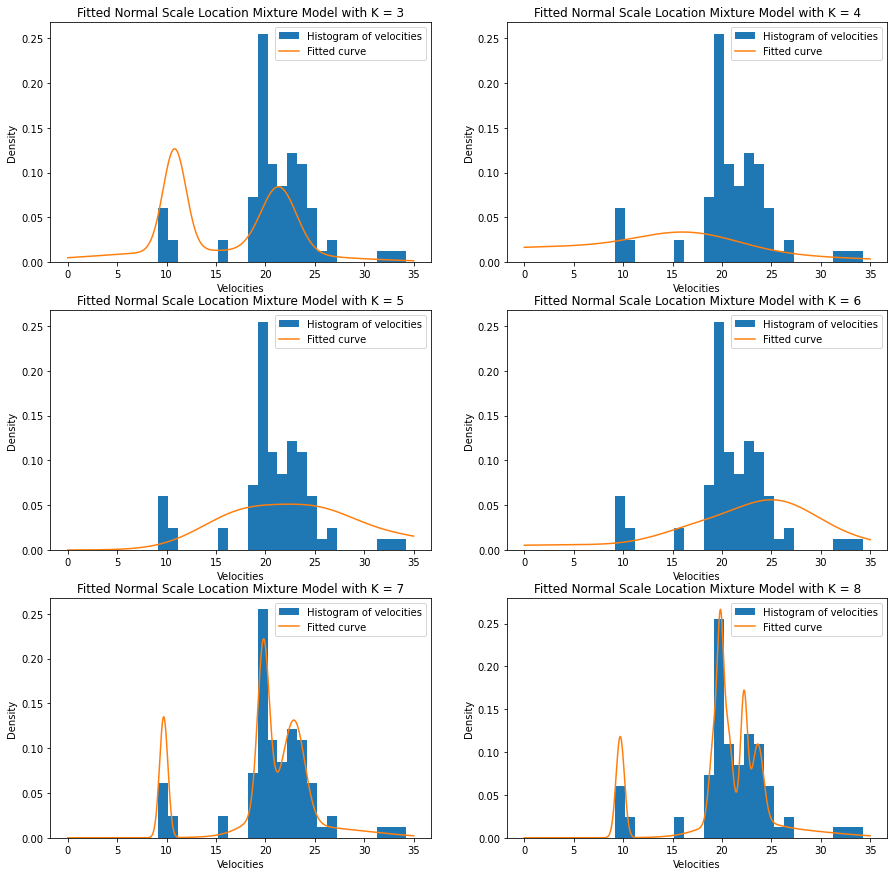

In [37]:
# Plots of fitted curves vs actual distribution.

plotter(new_y_values, velocities)

In [38]:
# Function to calculate AIC

def calculate_aic(data, parameters):
    aic_k = []
    k_vals = [3,4,5,6,7,8]
    k_indicator = 0 
    for param in parameters:
        vals =  2*(-1*calculate_q(data, param[0], param[1], param[2], k_vals[k_indicator]) + k_vals[k_indicator])
        aic_k.append(vals)
        k_indicator +=1    
    return aic_k

In [39]:
aic_k = calculate_aic(velocities, parameters2)

In [40]:
aic_k

[431.94792809066047,
 686.576928699443,
 617.8338582941506,
 654.3003678996872,
 438.1055876473959,
 391.2237881477489]

In [41]:
# Function to calculate BIC

def calculate_bic(data, parameters):
    bic_k = []
    k_vals = [3,4,5,6,7,8]
    k_indicator = 0 
    for param in parameters:
        vals =  -2*calculate_q(data, param[0], param[1], param[2], k_vals[k_indicator]) + k_vals[k_indicator]*log(len(data))
        bic_k.append(vals)
        k_indicator +=1    
    return bic_k

In [42]:
bic_k = calculate_bic(velocities, parameters2)
bic_k

[439.16808583245324,
 696.2038056885,
 629.8674545304718,
 668.7406833832728,
 454.9526223782457,
 410.47754212586295]